In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys

In [2]:
input_fname = 'test_toymodel.in'
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})
nTurn = 100000
nTurnSplit = 100
dTune = 4
nCore_y = 8
nCore_z = 6

In [3]:
# old_stdout = sys.stdout
# log_file   = open("log."+str(dTune),"w")
# sys.stdout = log_file

In [4]:
def getArgLostLive(TBTdata,rad):
    dummy,iLost = np.where(np.sqrt(TBTdata[:,0,:]**2+TBTdata[:,2,:]**2)>rad)
    iLost = set(iLost)
    iLive = set(np.arange(npt))
    iLive = iLive - iLost
    iLost=np.array(list(iLost))
    iLive=np.array(list(iLive))
    return iLost,iLive

##### grid data for contour plot

In [5]:
from scipy.interpolate import griddata
xmax = 0.01
xi = np.linspace(-xmax*1.1,xmax*1.1,240)
yi = np.linspace(-xmax*1.1,xmax*1.1,240)

# 1. Preparation

### 1.1 read InputFile and simplify lattice

In [6]:
beam, lattice = impact.readInputFile(input_fname);
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0
lattice[0].turns = 2*nTurn + nTurnSplit
betx = beam.distribution.betx
alfx = beam.distribution.alfx

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [7]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 100
lattice[2].tune_advance = 0.01*dTune

### 1.2. generate particles

In [8]:
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 100
for i in np.arange(-(nx-1)/2.0,(nx-1)/2.0+0.5):
    for j in np.arange(-(nx-1)/2.0,(nx-1)/2.0+0.5):
        x=2.0*i*xmax/nx
        y=2.0*j*xmax/nx
        if x**2+y**2<=xmax**2 :
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])

pTest = np.array(pTest)
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
impact.writeParticleData(pTest, ke, mass, freq)


npt = len(pTest)
pTest = None
beam.n_particles = npt
print('initial npt=',npt)

initial npt= 7860


# 2. FMA

### 2.1. run

In [9]:
print('===========================')
print('=========== FMA ===========')
print('===========================')

=========== FMA ===========


In [10]:
#######################
## pre-run for TBT_inv
#######################
TBT_Inv = impact.getElem('TBT_integral')
TBT_Inv.file_id = dTune
TBT_Inv.betx = betx
TBT_Inv.alfx = alfx
TBT_Inv.strength_t = 0.4
TBT_Inv.transverse_scale_c = 0.01
lattice.insert(1,TBT_Inv)


lattice[0].turns = 2048
impact.writeInputFile(beam,lattice) 
#impact.run(beam)

input error <- sum(beam.multi_charge.n_particles) not qual to beam.n_particles
  ... enforcing  beam.multi_charge.n_particles[0] to beam.n_particles
input error <- beam.multi_charge.current[0] not qual to beam.current
  ... enforcing  beam.multi_charge.current[0] to beam.current


In [11]:
indexTBT,TBTdataTmp_Inv = impact.readTBT_integral(dTune)
# back to Chad's definition of I2
TBTdataTmp_Inv[:,1,:]=TBTdataTmp_Inv[:,1,:]**2

In [12]:
TBT = impact.getElem('TBT')
TBT.file_id = dTune
lattice[1]=TBT

lattice[0].turns = 2*nTurn+nTurnSplit
impact.writeInputFile(beam,lattice) 
impact.run(beam)

In [13]:
indexTBT,TBTdataTmp = impact.readTBT(dTune,ke,mass,freq)

In [15]:
iLost,iLive = getArgLostLive(TBTdataTmp,rad=2.0*xmax*np.sqrt(2.0))
nptLive = len(iLive)
nptLost = len(iLost)
TBTdata = TBTdataTmp[:,:,iLive]
print('TBTdata.shape =',TBTdata.shape)
print('nptLost,nptLive =',nptLost,nptLive)
TBTdata_Inv = TBTdataTmp_Inv[:,:,iLive]
print('TBTdata_Inv.shape',TBTdata_Inv.shape)

TBTdata.shape = (200100, 6, 5466)
nptLost,nptLive = 2394 5466
TBTdata_Inv.shape (2048, 2, 5466)


In [16]:
TBTdataTmp = None
TBTdataTmp_Inv = None
indexTBT = None
np.save('TBTdata.Raw.Live',TBTdata)
np.save('TBTdata.Inv.Live',TBTdata_Inv)

In [17]:
# TBTdata = np.load('TBTdata.Raw.Live.npy')
# TBTdata_Inv = np.load('TBTdata.Inv.Live.npy')
# pDataInit = TBTdata[0,:,:]

In [ ]:
X = TBTdata[:,0,:] - 1j*(betx*TBTdata[:,1,:]+alfx*TBTdata[:,0,:])
Y = TBTdata[:,2,:] - 1j*(betx*TBTdata[:,3,:]+alfx*TBTdata[:,2,:])
TBTdata = None

tuneXbefore= np.zeros([1,nptLive])
tuneXafter = np.zeros([3,nptLive])
tuneYbefore= np.zeros([1,nptLive])
tuneYafter = np.zeros([3,nptLive])
for i in range(nptLive):
    tuneXbefore[:,i],amp,dummy = impact.util.naff(1,X[:nTurn,i],window_id=1)
    tuneXafter [:,i],amp,dummy = impact.util.naff(3,X[nTurn+nTurnSplit:,i],window_id=1)
    tuneYbefore[:,i],amp,dummy = impact.util.naff(1,Y[:nTurn,i],window_id=1)
    tuneYafter [:,i],amp,dummy = impact.util.naff(3,Y[nTurn+nTurnSplit:,i],window_id=1)

In [26]:
print(X.nbytes)
print(tuneXbefore[:,0])
print(tuneXafter[:,0])

17499945600
[3.52E-01]
[3.54E-01 3.54E-01 3.53E-01]


In [27]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode, nSample = arr.shape
    diff = np.abs(ref-arr)
    for i in range(nMode):
        for j in range(nSample):
            if (diff[i,j]>0.5):
                diff[i,j] = 1.0 - diff[i,j]
    return np.min(diff,0)

In [30]:
Xdiff = getClosestDiff(tuneXbefore,tuneXafter)
Ydiff = getClosestDiff(tuneYbefore,tuneYafter)
Adiff = np.sqrt(Xdiff**2 +Ydiff**2)

Xstd = np.std(Xdiff)
Ystd = np.std(Ydiff)
Astd = np.sqrt(Xstd**2+Ystd**2)

AdiffLog = np.log10(Adiff+1.0e-6)
XdiffLog = np.log10(Xdiff+1.0e-6)
YdiffLog = np.log10(Ydiff+1.0e-6)

iMaxX = np.argmax(Xdiff)
iMaxY = np.argmax(Ydiff)
iMaxA = np.argmax(Adiff)
iMinX = np.argmin(Xdiff)
iMinY = np.argmin(Ydiff)
iMinA = np.argmin(Adiff)

XdiffSig= 1.0/(1+np.exp(-0.5*(Xdiff-np.mean(Xdiff))/Xstd))
YdiffSig= 1.0/(1+np.exp(-0.5*(Ydiff-np.mean(Ydiff))/Ystd))
AdiffSig= 1.0/(1+np.exp(-0.5*(Adiff-np.mean(Adiff))/Astd))

### 2.2 plot

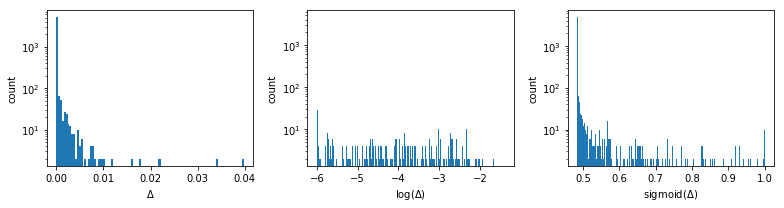

In [31]:
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
plt.hist(Adiff,bins=100);
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\Delta$')
plt.ylabel('count')
plt.subplot(1,3,2)
plt.hist(AdiffLog,bins=400);
plt.yscale('log', nonposy='clip')
plt.xlabel(r'log($\Delta$)')
plt.ylabel('count')
plt.subplot(1,3,3)
plt.hist(AdiffSig,bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel(r'sigmoid($\Delta$)')
plt.ylabel('count')
plt.tight_layout()
plt.savefig('FMA.hist.Adiff.'+str(dTune)+'.png',dpi=180)
# plt.close()


##### FFT

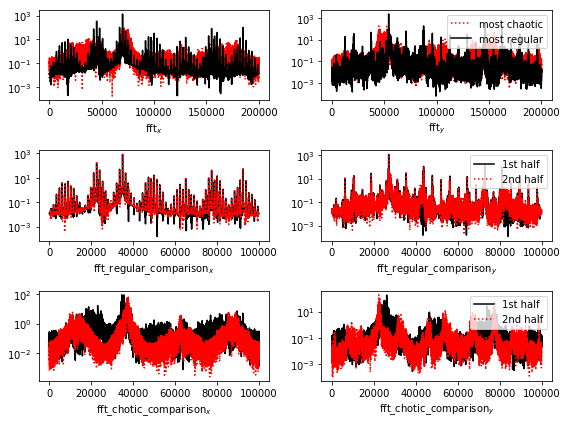

In [32]:
plt.figure(figsize=[8,6])
plt.subplot(3,2,1)
plt.semilogy(np.abs(np.fft.fft(X[:,iMaxX])),'r:')
plt.semilogy(np.abs(np.fft.fft(X[:,iMinX])),'k')
plt.xlabel('fft$_x$')
plt.subplot(3,2,2)
plt.semilogy(np.abs(np.fft.fft(Y[:,iMaxY])),'r:')
plt.semilogy(np.abs(np.fft.fft(Y[:,iMinY])),'k')
plt.legend(['most chaotic','most regular'],loc=1)
plt.xlabel('fft$_y$')
plt.subplot(3,2,3)
plt.semilogy(np.abs(np.fft.fft(X[:nTurn,iMinX])),'k')
plt.semilogy(np.abs(np.fft.fft(X[nTurn+nTurnSplit:,iMinX])),'r:')
plt.xlabel('fft_regular_comparison$_x$')
plt.subplot(3,2,4)
plt.semilogy(np.abs(np.fft.fft(Y[:nTurn,iMinY])),'k')
plt.semilogy(np.abs(np.fft.fft(Y[nTurn+nTurnSplit:,iMinY])),'r:')
plt.xlabel('fft_regular_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.subplot(3,2,5)
plt.semilogy(np.abs(np.fft.fft(X[:nTurn,iMaxX])),'k')
plt.semilogy(np.abs(np.fft.fft(X[nTurn+nTurnSplit:,iMaxX])),'r:')
plt.xlabel('fft_chotic_comparison$_x$')
plt.subplot(3,2,6)
plt.semilogy(np.abs(np.fft.fft(Y[:nTurn,iMaxY])),'k')
plt.semilogy(np.abs(np.fft.fft(Y[nTurn+nTurnSplit:,iMaxY])),'r:')
plt.xlabel('fft_chotic_comparison$_y$')
plt.legend(['1st half','2nd half'],loc=1)
plt.tight_layout()
plt.savefig('FMA.FFT.'+str(dTune)+'.png',dpi=180)
# plt.close()


##### tune plot

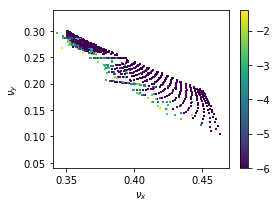

In [33]:
plt.figure(figsize=[4,3])
# x = np.arange(0.3,0.5,0.01)
# y = -5*x/4.0/5+1.0*5/4.0/5 + 1.0/4.0/5.0
# plt.plot(x,y)
f1=plt.scatter(tuneXbefore[0,:],tuneYbefore[0,:],c=AdiffLog,s=1.0,marker='s')
plt.xlim(np.array([0.3,0.43])+dTune*0.01)
plt.ylim(np.array([0,0.3])+dTune*0.01)
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FMA.tune.A.'+str(dTune)+'.png',dpi=180)
# plt.close()


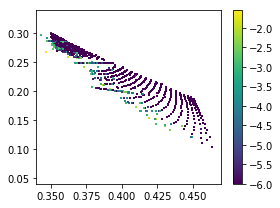

In [34]:
plt.figure(figsize=[4,3])
f1=plt.scatter(tuneXbefore[0,:],tuneYbefore[0,:],c=XdiffLog,s=1.0,marker='s')
plt.colorbar(f1)
plt.xlim(np.array([0.3,0.43])+dTune*0.01)
plt.ylim(np.array([0,0.3])+dTune*0.01)
plt.tight_layout()
plt.savefig('FMA.tune.X.'+str(dTune)+'.png',dpi=180)

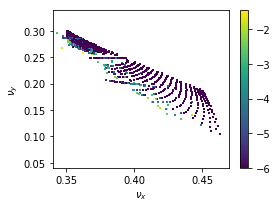

In [35]:
plt.figure(figsize=[4,3])
f1=plt.scatter(tuneXbefore[0,:],tuneYbefore[0,:],c=YdiffLog,s=1.0,marker='s')
plt.xlabel(r'$\nu_x$')
plt.ylabel(r'$\nu_y$')
plt.xlim(np.array([0.3,0.43])+dTune*0.01)
plt.ylim(np.array([0,0.3])+dTune*0.01)
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FMA.tune.Y.'+str(dTune)+'.png',dpi=180)
# plt.close()


In [36]:
X.shape

(200100, 5466)

##### Poincare

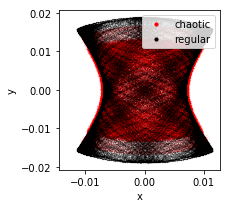

In [41]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[0,iMaxA]),np.real(Y[0,iMaxA]),c='r',s=10)
plt.scatter(np.real(X[0,iMinA]),np.real(Y[0,iMinA]),c='k',s=10)
plt.scatter(np.real(X[:,iMaxA]),np.real(Y[:,iMaxA]),c='r',s=0.001)
plt.scatter(np.real(X[:,iMinA]),np.real(Y[:,iMinA]),c='k',s=0.001)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['chaotic','regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.A.'+str(dTune)+'.png',dpi=180)
# plt.close()


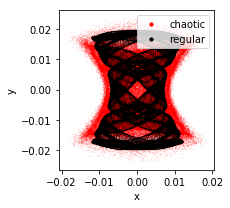

In [42]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[0,iMaxX]),np.real(Y[0,iMaxX]),c='r',s=10)
plt.scatter(np.real(X[0,iMinX]),np.real(Y[0,iMinX]),c='k',s=10)
plt.scatter(np.real(X[:,iMaxX]),np.real(Y[:,iMaxX]),c='r',s=0.001)
plt.scatter(np.real(X[:,iMinX]),np.real(Y[:,iMinX]),c='k',s=0.001)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['chaotic','regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.X.'+str(dTune)+'.png',dpi=180)
# plt.close()


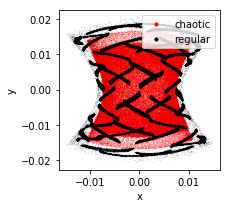

In [43]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X[0,iMaxY]),np.real(Y[0,iMaxY]),c='r',s=10)
plt.scatter(np.real(X[0,iMinY]),np.real(Y[0,iMinY]),c='k',s=10)
plt.scatter(np.real(X[:,iMaxY]),np.real(Y[:,iMaxY]),c='r',s=0.001)
plt.scatter(np.real(X[:,iMinY]),np.real(Y[:,iMinY]),c='k',s=0.001)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['chaotic','regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Poincare.Y.'+str(dTune)+'.png',dpi=180)
# plt.close()


##### Dynamic Aperture  (Log)

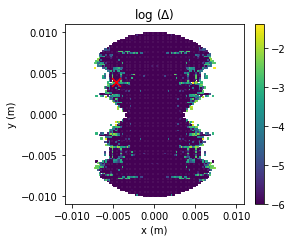

In [46]:
xmax = np.max([np.real(X[0,:]),np.real(Y[0,:])])
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),c=AdiffLog,s=1.6,marker='s')
plt.scatter(np.real(X[0,iMaxA]),np.real(Y[0,iMaxA]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'log ($\Delta$)')
plt.colorbar(f1)
plt.savefig('FMA.DA.Log.A.'+str(dTune)+'.png',dpi=180)
# plt.close()


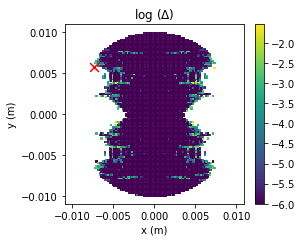

In [47]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),c=XdiffLog,s=1.6,marker='s')
plt.scatter(np.real(X[0,iMaxX]),np.real(Y[0,iMaxX]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'log ($\Delta$)')
plt.colorbar(f1)
plt.savefig('FMA.DA.Log.X.'+str(dTune)+'.png',dpi=180)
# plt.close()


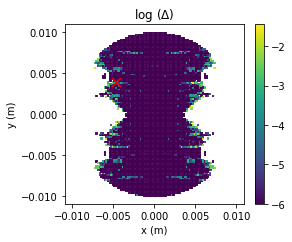

In [48]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),c=YdiffLog,s=1.6,marker='s')
plt.scatter(np.real(X[0,iMaxY]),np.real(Y[0,iMaxY]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'log ($\Delta$)')
plt.colorbar(f1)
plt.savefig('FMA.DA.Log.Y.'+str(dTune)+'.png',dpi=180)
# plt.close()


##### Dynamic Aperture  (Sigmoid)

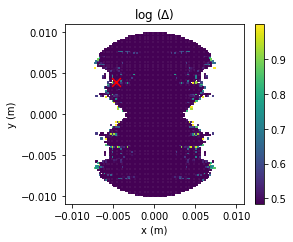

In [49]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),c=AdiffSig,s=1.6,marker='s')
plt.scatter(np.real(X[0,iMaxA]),np.real(Y[0,iMaxA]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'log ($\Delta$)')
plt.colorbar(f1)
plt.savefig('FMA.DA.Sig.A.'+str(dTune)+'.png',dpi=180)
# plt.close()


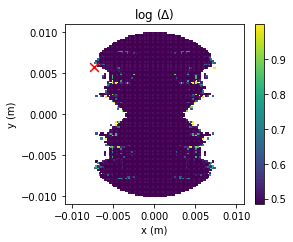

In [50]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),c=XdiffSig,s=1.6,marker='s')
plt.scatter(np.real(X[0,iMaxX]),np.real(Y[0,iMaxX]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'log ($\Delta$)')
plt.colorbar(f1)
plt.savefig('FMA.DA.Sig.X.'+str(dTune)+'.png',dpi=180)
# plt.close()


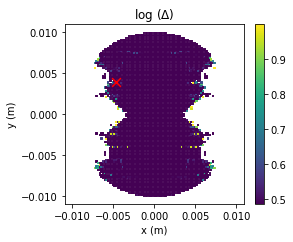

In [51]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X[0,:]),np.real(Y[0,:]),c=YdiffSig,s=1.6,marker='s')
plt.scatter(np.real(X[0,iMaxY]),np.real(Y[0,iMaxY]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'log ($\Delta$)')
plt.colorbar(f1)
plt.savefig('FMA.DA.Sig.Y.'+str(dTune)+'.png',dpi=180)
# plt.close()



##### Inv

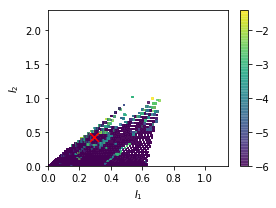

In [52]:
plt.figure(figsize=[4,3])
f1=plt.scatter(TBTdata_Inv[0,0,:],TBTdata_Inv[0,1,:],c=AdiffLog,s=3.0,marker='s',alpha=0.5)
plt.scatter(TBTdata_Inv[0,0,iMaxA],TBTdata_Inv[0,1,iMaxA],c='r',s=77,marker='x')
plt.xlim(0,1.15)
plt.ylim(0,2.3)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FMA.Inv.Log.A.'+str(dTune)+'.png',dpi=180)
# plt.close()


In [ ]:
plt.figure(figsize=[4,3])
f1=plt.scatter(TBTdata_Inv[0,0,:],TBTdata_Inv[0,1,:],c=AdiffSig,s=3.0,marker='s',alpha=0.5)
plt.scatter(TBTdata_Inv[0,0,iMaxA],TBTdata_Inv[0,1,iMaxA],c='r',s=77,marker='x')
plt.xlim(0,1.15)
plt.ylim(0,2.3)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FMA.Inv.Sig.A.'+str(dTune)+'.png',dpi=180)
# plt.close()


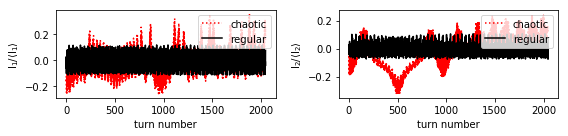

In [53]:
plt.figure(figsize=[8,2])
plt.subplot(1,2,1)
plt.plot(TBTdata_Inv[:,0,iMaxA]/np.mean(TBTdata_Inv[:,0,iMaxA])-1.0,'r:')
plt.plot(TBTdata_Inv[:,0,iMinA]/np.mean(TBTdata_Inv[:,0,iMinA])-1.0,'k')
plt.xlabel('turn number')
plt.ylabel(r'$\mathrm{I}_1/\langle \mathrm{I}_1 \rangle $')
plt.legend(['chaotic','regular'],loc=1)
plt.subplot(1,2,2)
plt.plot(TBTdata_Inv[:,1,iMaxA]/np.mean(TBTdata_Inv[:,1,iMaxA])-1.0,'r:')
plt.plot(TBTdata_Inv[:,1,iMinA]/np.mean(TBTdata_Inv[:,1,iMinA])-1.0,'k')
plt.ylabel(r'$\mathrm{I}_2/\langle \mathrm{I}_2 \rangle $')
plt.xlabel('turn number')
plt.legend(['chaotic','regular'],loc=1)
plt.tight_layout()
plt.savefig('FMA.Inv.'+str(dTune)+'.png',dpi=180)
# plt.close()


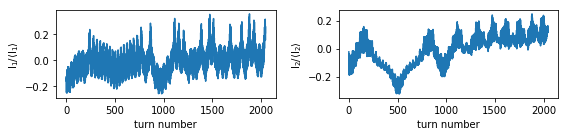

In [54]:
plt.figure(figsize=[8,2])
plt.subplot(1,2,1)
plt.plot(TBTdata_Inv[:,0,iMaxA]/np.mean(TBTdata_Inv[:,0,iMaxA])-1.0)
plt.xlabel('turn number')
plt.ylabel(r'$\mathrm{I}_1/\langle \mathrm{I}_1 \rangle $')
plt.subplot(1,2,2)
plt.plot(TBTdata_Inv[:,1,iMaxA]/np.mean(TBTdata_Inv[:,1,iMaxA])-1.0)
plt.xlabel('turn number')
plt.ylabel(r'$\mathrm{I}_2/\langle \mathrm{I}_2 \rangle $')
plt.tight_layout()
plt.savefig('FMA.Inv.Chaotic'+str(dTune)+'.png',dpi=180)
# plt.close()


# 3. Backward

In [55]:
print('===========================')
print('======== Backward =========')
print('===========================')

======== Backward =========


In [56]:
X=None
Y=None
TBTdata = np.load('TBTdata.Raw.Live.npy')

### 3.1 run

In [57]:
pTest = np.zeros([nptLive,9])
for i in range(nptLive):
    pTest[i,:6] = TBTdata[nTurn,:6,i]
    pTest[i,8] = iLive[i]+1 #i+1
pTest[:,6] = q_m
impact.writeParticleData(pTest, ke, mass, freq)

In [59]:
TBTdata = None

In [58]:
latticeB = copy(lattice[::-1])
latticeB.insert(0,copy(lattice[0]))
latticeB.pop()
#latticeB.pop(3)
latticeB[0].turns = nTurn

for i in range(len(latticeB)):
    if 'length' in latticeB[i]:
        latticeB[i].length = -latticeB[i].length
    if latticeB[i].type == 'linear_matrix_map':
        latticeB[i].tune_advance                 =-latticeB[i].tune_advance
        latticeB[i].nonlinear_insert_tuneAdvance =-latticeB[i].nonlinear_insert_tuneAdvance
        latticeB[i].nonlinear_insert_length      =-latticeB[i].nonlinear_insert_length
        
impact.writeInputFile(beam,latticeB)
impact.run(beam)

In [ ]:
pDataMid = impact.readParticleData(-111110,ke,mass,freq)
pDataOut = impact.readParticleData(-111111,ke,mass,freq)

In [63]:
TBTdata = np.load('TBTdata.Raw.Live.npy')
X0 = TBTdata[:nTurn,0,:] -1j*(betx*TBTdata[:nTurn,1,:]+alfx*TBTdata[:nTurn,0,:])
Y0 = TBTdata[:nTurn,2,:] -1j*(betx*TBTdata[:nTurn,3,:]+alfx*TBTdata[:nTurn,2,:])
TBTdata = None

In [64]:
indexTBT,TBTdataFB = impact.readTBT(dTune,ke,mass,freq)
indexTBT = None
X1 = TBTdataFB[::-1,0,:] - 1j*(betx*TBTdataFB[::-1,1,:]+alfx*TBTdataFB[::-1,0,:])
Y1 = TBTdataFB[::-1,2,:] - 1j*(betx*TBTdataFB[::-1,3,:]+alfx*TBTdataFB[::-1,2,:])
TBTdataFB = None

In [ ]:
# pDataOut= impact.readParticleData(-111111,ke,mass,freq)
# print('----Berr of 10 particles----')
# for i in range(10):
#     print('init=',end='')
#     print(pDataOut[i,:4])
#     print('diff=',end='')
#     print(pDataOut[i,:4]-TBTdata[0,:4,i])
# print('-----------------------------')

In [65]:
Xdiff = np.abs(X1-X0)**2
Ydiff = np.abs(Y1-Y0)**2
Adiff = Xdiff+Ydiff

Xdiff=np.sqrt(np.sum(Xdiff,0)/nTurn)
Ydiff=np.sqrt(np.sum(Ydiff,0)/nTurn)
Adiff=np.sqrt(np.sum(Adiff,0)/nTurn)

iMaxX = np.argmax(Xdiff)
iMaxY = np.argmax(Ydiff)
iMaxA = np.argmax(Adiff)
iMinX = np.argmin(Xdiff)
iMinY = np.argmin(Ydiff)
iMinA = np.argmin(Adiff)

XdiffSig= 1.0/(1+np.exp(-1.0*(Xdiff-np.mean(Xdiff))/np.std(Xdiff)))
YdiffSig= 1.0/(1+np.exp(-1.0*(Ydiff-np.mean(Ydiff))/np.std(Ydiff)))
AdiffSig= 1.0/(1+np.exp(-1.0*(Adiff-np.mean(Adiff))/np.std(Adiff)))

XdiffLog = np.log10(Xdiff+1.0e-15)
YdiffLog = np.log10(Ydiff+1.0e-15)
AdiffLog = np.log10(Adiff+1.0e-15)

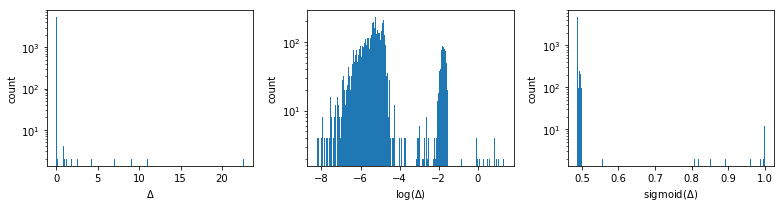

In [66]:
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
plt.hist(Adiff,bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\Delta$')
plt.ylabel('count')
plt.subplot(1,3,2)
plt.hist(AdiffLog,bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel(r'log($\Delta$)')
plt.ylabel('count')
plt.subplot(1,3,3)
plt.hist(AdiffSig,bins=200);
plt.yscale('log', nonposy='clip')
plt.xlabel(r'sigmoid($\Delta$)')
plt.ylabel('count')
plt.tight_layout()
plt.savefig('FB.hist.Adiff.'+str(dTune)+'.png',dpi=180)
# plt.close()

### 3.2 plots

##### Poincare

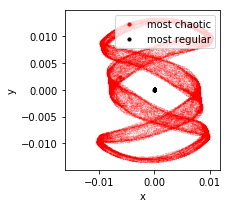

In [69]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X0[0,iMaxA]),np.real(Y0[0,iMaxA]),c='r',s=10)
plt.scatter(np.real(X0[0,iMinA]),np.real(Y0[0,iMinA]),c='k',s=10)
plt.scatter(np.real(X0[:,iMaxA]),np.real(Y0[:,iMaxA]),c='r',s=0.001)
plt.scatter(np.real(X0[:,iMinA]),np.real(Y0[:,iMinA]),c='k',s=0.001)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.Poincare.A.'+str(dTune)+'.png',dpi=180)
# plt.close()


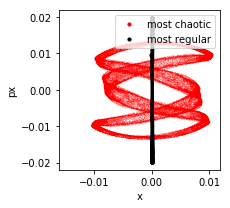

In [70]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X0[0,iMaxX]),np.real(Y0[0,iMaxX]),c='r',s=10)
plt.scatter(np.real(X0[0,iMinX]),np.real(Y0[0,iMinX]),c='k',s=10)
plt.scatter(np.real(X0[:,iMaxX]),np.real(Y0[:,iMaxX]),c='r',s=0.001)
plt.scatter(np.real(X0[:,iMinX]),np.real(Y0[:,iMinX]),c='k',s=0.001)
plt.xlabel('x')
plt.ylabel('px')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.Poincare.X.'+str(dTune)+'.png',dpi=180)
# plt.close()


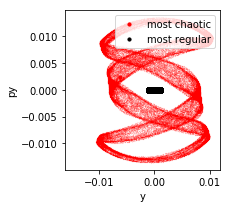

In [71]:
plt.figure(figsize=[3.3,3])
plt.scatter(np.real(X0[0,iMaxY]),np.real(Y0[0,iMaxY]),c='r',s=10)
plt.scatter(np.real(X0[0,iMinY]),np.real(Y0[0,iMinY]),c='k',s=10)
plt.scatter(np.real(X0[:,iMaxY]),np.real(Y0[:,iMaxY]),c='r',s=0.001)
plt.scatter(np.real(X0[:,iMinY]),np.real(Y0[:,iMinY]),c='k',s=0.001)
plt.xlabel('y')
plt.ylabel('py')
plt.legend(['most chaotic','most regular'],loc=1)
plt.tight_layout()
plt.savefig('FB.Poincare.Y.'+str(dTune)+'.png',dpi=180)
# plt.close()


##### Dynamic Aperture Log

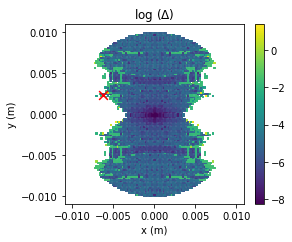

In [73]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X0[0,:]),np.real(Y0[0,:]),c=AdiffLog,s=1.6,marker='s')
plt.scatter(np.real(X0[0,iMaxA]),np.real(Y0[0,iMaxA]),c='r',s=77,marker='x')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'log ($\Delta$)')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.colorbar(f1)
plt.savefig('FB.DA.Log.A.'+str(dTune)+'.png',dpi=180)
# plt.close()

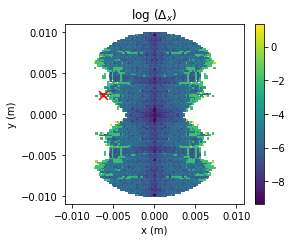

In [75]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X0[0,:]),np.real(Y0[0,:]),c=XdiffLog,s=1.6,marker='s')
plt.scatter(np.real(X0[0,iMaxX]),np.real(Y0[0,iMaxX]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'log ($\Delta_x$)')
plt.colorbar(f1)
plt.savefig('FB.DA.Log.X.'+str(dTune)+'.png',dpi=180)
# plt.close()


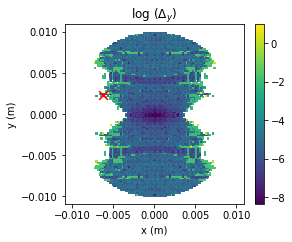

In [76]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X0[0,:]),np.real(Y0[0,:]),c=YdiffLog,s=1.6,marker='s')
plt.scatter(np.real(X0[0,iMaxY]),np.real(Y0[0,iMaxY]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'log ($\Delta_y$)')
plt.colorbar(f1)
plt.savefig('FB.DA.Log.Y.'+str(dTune)+'.png',dpi=180)
# plt.close()

##### Dynamic Aperture Sig

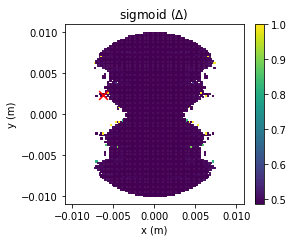

In [78]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X0[0,:]),np.real(Y0[0,:]),c=AdiffSig,s=1.6,marker='s')
plt.scatter(np.real(X0[0,iMaxA]),np.real(Y0[0,iMaxA]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'sigmoid ($\Delta$)')
plt.colorbar(f1)
plt.savefig('FB.DA.Sig.A.'+str(dTune)+'.png',dpi=180)
# plt.close()


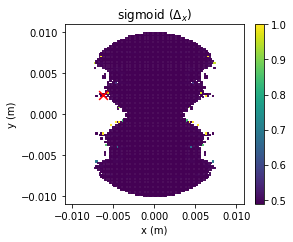

In [79]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X0[0,:]),np.real(Y0[0,:]),c=XdiffSig,s=1.6,marker='s')
plt.scatter(np.real(X0[0,iMaxX]),np.real(Y0[0,iMaxX]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'sigmoid ($\Delta_x$)')
plt.colorbar(f1)
plt.savefig('FB.DA.Sig.X.'+str(dTune)+'.png',dpi=180)
# plt.close()


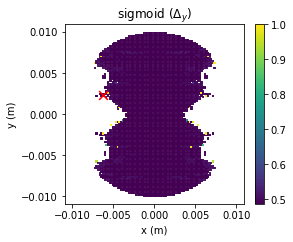

In [80]:
plt.figure(figsize=[4,3.3])
f1=plt.scatter(np.real(X0[0,:]),np.real(Y0[0,:]),c=YdiffSig,s=1.6,marker='s')
plt.scatter(np.real(X0[0,iMaxY]),np.real(Y0[0,iMaxY]),c='r',s=77,marker='x')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(-xmax*1.1,xmax*1.1)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title(r'sigmoid ($\Delta_y$)')
plt.colorbar(f1)
plt.savefig('FB.DA.Sig.Y.'+str(dTune)+'.png',dpi=180)
# plt.close()


##### Inv

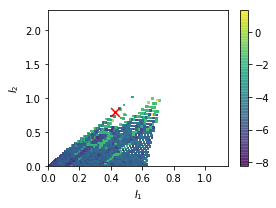

In [81]:
plt.figure(figsize=[4,3])
f1=plt.scatter(TBTdata_Inv[0,0,:],TBTdata_Inv[0,1,:],c=AdiffLog,s=3.0,marker='s',alpha=0.5)
plt.scatter(TBTdata_Inv[0,0,iMaxA],TBTdata_Inv[0,1,iMaxA],c='r',s=77,marker='x')
plt.xlim(0,1.15)
plt.ylim(0,2.3)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FB.Inv.Log.A.'+str(dTune)+'.png',dpi=180)
# plt.close()


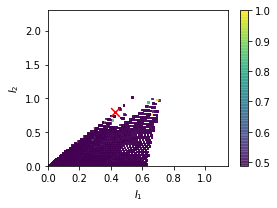

In [82]:
plt.figure(figsize=[4,3])
f1=plt.scatter(TBTdata_Inv[0,0,:],TBTdata_Inv[0,1,:],c=AdiffSig,s=3.0,marker='s',alpha=0.5)
plt.scatter(TBTdata_Inv[0,0,iMaxA],TBTdata_Inv[0,1,iMaxA],c='r',s=77,marker='x')
plt.xlim(0,1.15)
plt.ylim(0,2.3)
plt.xlabel(r'$I_1$')
plt.ylabel(r'$I_2$')
plt.colorbar(f1)
plt.tight_layout()
plt.savefig('FB.Inv.Sig.A.'+str(dTune)+'.png',dpi=180)
# plt.close()


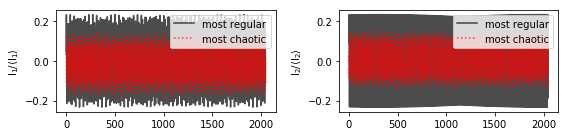

In [86]:
plt.figure(figsize=[8,2])
plt.subplot(1,2,1)
plt.plot(TBTdata_Inv[:,0,iMinA]/np.mean(TBTdata_Inv[:,0,iMinA])-1.0,'k',alpha=0.7)
plt.plot(TBTdata_Inv[:,0,iMaxA]/np.mean(TBTdata_Inv[:,0,iMaxA])-1.0,'r:',alpha=0.7)
plt.ylabel(r'$\mathrm{I}_1/\langle \mathrm{I}_1 \rangle $')
plt.legend(['most regular','most chaotic'],loc=1)
plt.subplot(1,2,2)
plt.plot(TBTdata_Inv[:,1,iMinA]/np.mean(TBTdata_Inv[:,1,iMinA])-1.0,'k',alpha=0.7)
plt.plot(TBTdata_Inv[:,1,iMaxA]/np.mean(TBTdata_Inv[:,1,iMaxA])-1.0,'r:',alpha=0.7)
plt.ylabel(r'$\mathrm{I}_2/\langle \mathrm{I}_2 \rangle $')
plt.legend(['most regular','most chaotic'],loc=1)
plt.tight_layout()
plt.savefig('FB.Inv.'+str(dTune)+'.png',dpi=180)
# plt.close()


In [ ]:
sys.stdout = old_stdout
log_file.close()